# Анализ данных в задаче кредитного скоринга

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* default - индикатор невозврата денежных средств

In [1]:
import pandas as pd
import numpy as np

import scipy
import math

from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

import sklearn
%pylab inline

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1

    Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   
        a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
        b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [4]:
d1 = data.loc[(data['default'] == 1)].LIMIT_BAL # не вернули кредит
d2 = data.loc[(data['default'] == 0)].LIMIT_BAL # вернули кредит

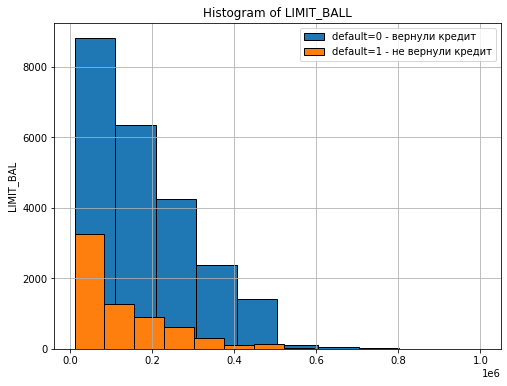

In [5]:
pylab.figure(1, figsize=(8,6))
pylab.subplot(111)
pylab.grid()

pylab.title('Histogram of LIMIT_BALL')
pylab.hist(d2,label="default=0 - вернули кредит", edgecolor='k')
pylab.hist(d1, label="default=1 - не вернули кредит", edgecolor='k')

pylab.ylabel('LIMIT_BAL')
pylab.legend()
pylab.show()

   Кредитный лимит по карте – это максимальная сумма, в пределах которой банк готов предоставить вам кредит. Говоря проще – это предел, в рамках которого кредитная организация доверяет вам деньги. 
    Из построенного графика видно, что кредитный лимит выше у тех, кто уже возвращал ранее кредит

### Проверка гипотезы о равенстве медианных значений лимита с помощью интервальной оценки

$H_0\colon Me(X_1) = Me(X_2)$

$H_1\colon Me(X_1) != Me(X_2)$

In [6]:
d1.median(), d2.median()

(90000.0, 150000.0)

Построим ДИ для оценки медиан d1 и d2 биномиального распределения:

In [7]:
def zconfint_bin(n, p, alpha=0.001):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * math.sqrt(var)))
    u_bound = int(round(m + z_stat * math.sqrt(var)))
    return (l_bound, u_bound)

In [8]:
l_0, r_0 = zconfint_bin(len(d2), 0.5)
l_1, r_1 = zconfint_bin(len(d1), 0.5)

val_0 = np.sort(d2.values)
val_1 = np.sort(d1.values)

print(f'Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (val_0[l_0], val_0[r_0]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (val_1[l_1], val_1[r_1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 160000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 100000]


Таким образом, видно, что заемщики, которые возвращают кредит (default = 0), в среднем берут в кредит большую сумму. Медианные значения для двух рассматривемых групп не совпадают, так как ДИ не пересекаются.

### Проверка гипотезы о равенстве распределений с помощью непараметрического критерия 

Воспользуемся ранговым критерием Манна-Уитни для независимых выборок:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [9]:
print("p_value:", round(stats.mannwhitneyu(d1, d2)[1], 100))

p_value: 0.0


Таким образом, мы получили очень маленькое значение p_value, значит нулевая гипотеза будет отвергнута на уровне 0.05. С помощью непараметрического критерия мы также убеждаемся в том, что разница ЭФР довольно велика, что не позволяет сделать вывод о справедливости нулевой гипотезы.

Результаты эксперимента значимы, так как изначально разница медиан d1 и d2 достаточно велика, также из графиков видно, что распределения имею разный вид.

## Задание 2

Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [10]:
pay = data.loc[(data['default'] == 0)].SEX
no_pay = data.loc[(data['default'] == 1)].SEX

In [11]:
pay.value_counts()

2    14349
1     9015
Name: SEX, dtype: int64

In [12]:
men_pay = pay.value_counts()[1]
women_pay= pay.value_counts()[2]
men_npay = no_pay.value_counts()[1]
women_npay = no_pay.value_counts()[2]

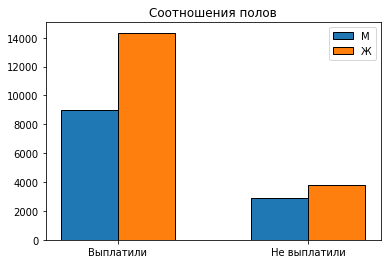

In [13]:
cat_par = ['Выплатили', 'Не выплатили']
g1 = [men_pay, men_npay ] 
g2 = [women_pay, women_npay]
width = 0.3
x = np.arange(len(cat_par))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='М',  edgecolor='k')
rects2 = ax.bar(x + width/2, g2, width, label='Ж',  edgecolor='k')
ax.set_title('Соотношения полов')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend()

### Проверка гипотезы об отличие гендерного состава групп вернувших и не вернувших кредит (ДИ)

Статистический Z-критерий для разности долей для двух независимых выборок:

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

    H0: гендерный состав не отличается
    H1: гендерный состав отличается

In [14]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * math.sqrt(abs(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2)))
    right_boundary = (p1 - p2) + z * math.sqrt(abs(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2)))
    
    return (left_boundary, right_boundary)

In [15]:
proportions_confint_diff_ind(pay, no_pay)

(0.021064699635331474, 0.07311831108919392)

Таким образом, разница долей изменяется в полученном интервале от 2 до 7 %

In [16]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [17]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [18]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [19]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [20]:
print("p-value: %f" % permutation_test(pay, no_pay, max_permutations = 10000))

p-value: 0.000100


In [21]:
print("p-value: %f" % permutation_test(pay, no_pay, max_permutations = 500))

p-value: 0.002000


## Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?  

In [22]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

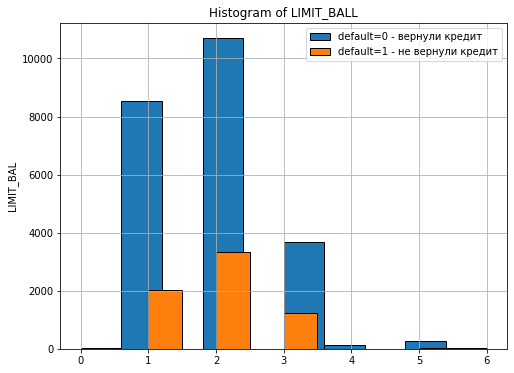

In [23]:
pylab.figure(1, figsize=(8,6))
pylab.subplot(111)
pylab.grid()

pylab.title('Histogram of LIMIT_BALL')
pylab.hist(data.EDUCATION.loc[data.default == 0], label="default=0 - вернули кредит", edgecolor='k')
pylab.hist(data.EDUCATION.loc[data.default == 1], label="default=1 - не вернули кредит", edgecolor='k')

pylab.ylabel('LIMIT_BAL')
pylab.legend()
pylab.show()

In [24]:
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                     columns=['product_name'], fill_value = 0)

NameError: name 'sales' is not defined

In [ ]:
new_df = data[['EDUCATION','default']]

In [ ]:
edu_1 = data.loc[(data['default'] == 1)].EDUCATION
edu_0 = data.loc[(data['default'] == 0)].EDUCATION

In [ ]:
edu_1.value_counts()

In [ ]:
edu_0.value_counts()

Заметим, что все люди, имеющие степень доктора(0) в данной выборке вернули кредит. Также довольно большой процент магистров(1) и бакалавров(2) возвращают кредит, в отличие от людей с начальным образованием(3). 

### Проверка на соответствие распределения равномерному с помощью критерия Пирсона хи-квадрат

    H0: рассматривая величина имеет равномерное распределение
    H1: H0 не верна

In [114]:
sparse_sales = pd.pivot_table(data, values='default', index='ID',
                     columns=['EDUCATION'], fill_value = 0)

In [115]:
sparse_sales

EDUCATION,0,1,2,3,4,5,6
ID,,,,,,,
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
29996,0,0,0,0,0,0,0
29997,0,0,0,0,0,0,0
29998,0,0,1,0,0,0,0


## Задача 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [106]:
mar = data.MARRIAGE
mar.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

<AxesSubplot:>

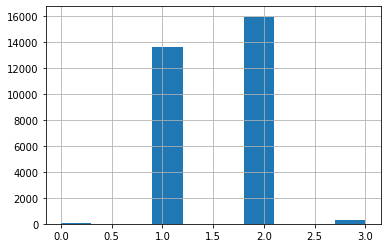

In [114]:
mar.hist()

In [107]:
mar_0 = data.MARRIAGE.loc[data.default == 0]
mar_1 = data.MARRIAGE.loc[data.default == 1]

Составим таблицу сопряжённости для признаков default и MARRIAGE:

In [108]:
table = np.empty( (len(mar.value_counts()), 2) )
for i in range(len(mar.value_counts())):
    table[i, 0] = len(mar_0.loc[mar_0 == i])
    table[i, 1] = len(mar_1.loc[mar_1 == i])
table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

Вычислим коэффициент V Крамера:

In [110]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [113]:
print('V Cramer value: %.4f' % cramers_stat(table))

V Cramer value: 0.0345


Таким образом, коэффициент Крамера принимает значение, близкое к нулю, значит взаимосвязь отсутствует.
Практическая значимость присутствует, нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

## Задача 5

Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [116]:
age_0 = data.AGE.loc[data.default == 0]
age_1 = data.AGE.loc[data.default == 1]

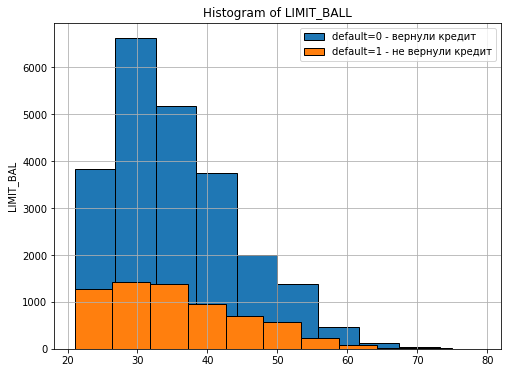

In [117]:
pylab.figure(1, figsize=(8,6))
pylab.subplot(111)
pylab.grid()

pylab.title('Histogram of LIMIT_BALL')
pylab.hist(age_0, label="default=0 - вернули кредит", edgecolor='k')
pylab.hist(age_1, label="default=1 - не вернули кредит", edgecolor='k')

pylab.ylabel('LIMIT_BAL')
pylab.legend()
pylab.show()

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.
        * H0: медианные значения равны
        * H1: медианные значения отличаются

In [119]:
age_0.mean(), age_1.mean() 

(35.417265879130284, 35.72573839662447)

Уже на данном этапе видно, что медианы распеделений совпадают.

### Доверительный интервал для медианы на основе бутстрепа

In [121]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [122]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [125]:
age_0_med = list(map(np.median, get_bootstrap_samples(age_0.values, 100)))
age_1_med = list(map(np.median, get_bootstrap_samples(age_1.values, 100)))

bnd_0 = stat_intervals(age_0_med, 0.05)
bnd_1 = stat_intervals(age_1_med, 0.05)

print('Conf. int. median AGE for default = 0: [%f, %f]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median AGE for default = 1: [%f, %f]' % (bnd_1[0], bnd_1[1]))

Conf. int. median AGE for default = 0: [34.000000, 34.000000]
Conf. int. median AGE for default = 1: [34.000000, 35.000000]


Таким образом, доверительные интервалы для медиан пересекаются, значит можно принять нудевую гипотезу.